In [1]:
import os
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt

In [2]:
defdir="D:\Bitirme projeleri\datasets\Düzenlenmiş olanlar\esc50"
os.chdir(defdir)
esc50=pd.read_csv("esc50.csv")

In [3]:


from glob import glob
import numpy as np
import scipy
	
import os
defdir=os.getcwd()

try:
  os.mkdir('{0}/audio/audio/'.format(defdir))
except:print("")
  
os.chdir('{0}/audio/audio/'.format(defdir))

In [5]:
import numpy as np
from scipy.signal import lfilter
from scipy.fftpack import dct


# see function mfcc.m from Slaneys Auditory Toolbox (Matlab)
def ToolGammatoneFb(afAudioData, f_s, iNumBands=20, f_low=100):

    # initialization
    fEarQ = 9.26449
    fBW = 24.7
    iOrder = 1
    T = 1 / f_s

    # allocate output memory
    X = np.zeros([iNumBands, afAudioData.shape[0]])

    # compute the mid frequencies
    f_c = getMidFrequencies(f_low, f_s / 2, iNumBands, fEarQ, fBW)

    # compute the coefficients
    [afCoeffB, afCoeffA] = getCoeffs(f_c, 1.019 * 2 * np.pi * (((f_c / fEarQ)**iOrder + fBW**iOrder)**(1 / iOrder)), T)

    # do the (cascaded) filter process
    for k in range(0, iNumBands):
        X[k, :] = afAudioData
        for j in range(0, 4):
            X[k, :] = lfilter(afCoeffB[j, :, k], afCoeffA[j, :, k], X[k, :])
           
   # K_1=np.log(X)
   #K_2=dct(K_1,2,afAudioData.shape[0])

    return (X)


# see function ERBSpace.m from Slaneys Auditory Toolbox
def getMidFrequencies(f_low, f_hi, iNumBands, fEarQ, fBW):

    freq = np.log((f_low + fEarQ * fBW) / (f_hi + fEarQ * fBW)) / iNumBands
    f_c = np.exp(np.arange(1, iNumBands + 1) * freq)
    f_c = -(fEarQ * fBW) + f_c * (f_hi + fEarQ * fBW)

    return (f_c)


# see function MakeERBFilters.m from Slaneys Auditory Toolbox
def getCoeffs(f_c, B, T):

    fCos = np.cos(2 * f_c * np.pi * T)
    fSin = np.sin(2 * f_c * np.pi * T)
    fExp = np.exp(B * T)
    fSqrtA = 2 * np.sqrt(3 + 2**(3 / 2))
    fSqrtS = 2 * np.sqrt(3 - 2**(3 / 2))

    A0 = T
    A2 = 0
    B0 = 1
    B1 = -2 * fCos / fExp
    B2 = np.exp(-2 * B * T)

    A11 = -(2 * T * fCos / fExp + fSqrtA * T * fSin / fExp) / 2
    A12 = -(2 * T * fCos / fExp - fSqrtA * T * fSin / fExp) / 2
    A13 = -(2 * T * fCos / fExp + fSqrtS * T * fSin / fExp) / 2
    A14 = -(2 * T * fCos / fExp - fSqrtS * T * fSin / fExp) / 2

    fSqrtA = np.sqrt(3 + 2**(3 / 2))
    fSqrtS = np.sqrt(3 - 2**(3 / 2))
    fArg = (f_c * np.pi * T) * 1j

    fExp1 = 2 * np.exp(4 * fArg)
    fExp2 = 2 * np.exp(-(B * T) + 2 * fArg)

    afGain = np.abs((-fExp1 * T + fExp2 * T * (fCos - fSqrtS * fSin)) *
                    (-fExp1 * T + fExp2 * T * (fCos + fSqrtS * fSin)) *
                    (-fExp1 * T + fExp2 * T * (fCos - fSqrtA * fSin)) *
                    (-fExp1 * T + fExp2 * T * (fCos + fSqrtA * fSin)) /
                    (-2 / np.exp(2 * B * T) - fExp1 + (2 + fExp1) / fExp)**4)

    # this is Slaney's compact format - now resort into 3D Matrices
    # fcoefs = [A0*ones(length(f_c),1) A11 A12 A13 A14 A2*ones(length(f_c),1) B0*ones(length(f_c),1) B1 B2 afGain];

    afCoeffB = np.zeros([4, 3, B.size])
    afCoeffA = np.zeros([4, 3, B.size])

    for k in range(0, B.size):
        afCoeffB[0, :, k] = [A0, A11[k], A2] / afGain[k]
        afCoeffA[0, :, k] = [B0, B1[k], B2[k]]

        afCoeffB[1, :, k] = [A0, A12[k], A2]
        afCoeffA[1, :, k] = [B0, B1[k], B2[k]]

        afCoeffB[2, :, k] = [A0, A13[k], A2]
        afCoeffA[2, :, k] = [B0, B1[k], B2[k]]

        afCoeffB[3, :, k] = [A0, A14[k], A2]
        afCoeffA[3, :, k] = [B0, B1[k], B2[k]]

    return (afCoeffB, afCoeffA)


#############################################################################
#    # initialization
#    f_start         = 133.3333
#
#    iNumLinFilters  = 13
#    iNumLogFilters  = 27
#    iNumFilters     = iNumLinFilters + iNumLogFilters
#
#    linearSpacing   = 66.66666666
#    logSpacing      = 1.0711703
#
#    # compute band frequencies
#    f = np.zeros(iNumFilters+2)
#    f[np.arange(0,iNumLinFilters)] = f_start + np.arange(0,iNumLinFilters)*linearSpacing
#    f[np.arange(iNumLinFilters,iNumFilters+2)] = f[iNumLinFilters-1] * logSpacing**np.arange(1,iNumLogFilters+3)
#
#    # sanity check
#    if f[iNumLinFilters-1]>=f_s/2:
#        f = f[f<f_s/2]
#        iNumFilters = f.shape[0] - 2
#
#    f_l = f[np.arange(0,iNumFilters)]
#    f_c = f[np.arange(1,iNumFilters+1)]
#    f_u = f[np.arange(2,iNumFilters+2)]
#
#    # allocate memory for filters and set max amplitude
#    H = np.zeros([iNumFilters,iFftLength])
#    afFilterMax = 2 / (f_u - f_l)
#    f_k = np.arange(0,iFftLength)/(iFftLength-1)*f_s/2
#
#    # compute the transfer functions
#    for c in range(0,iNumFilters):
#        #lower filter slope
#        i_l = np.argmax(f_k>f_l[c])
#        i_u = np.max([0, np.argmin(f_k <= f_c[c])-1])
#        H[c,np.arange(i_l, i_u+1)] = afFilterMax[c] * (f_k[np.arange(i_l, i_u+1)]-f_l[c])/(f_c[c]-f_l[c])
#        #upper filter slope
#        i_l = i_u + 1
#        i_u = np.max([0, np.argmin(f_k < f_u[c])-1])
#        H[c,np.arange(i_l, i_u+1)] = afFilterMax[c] * (f_u[c]-f_k[np.arange(i_l, i_u+1)])/(f_u[c]-f_c[c])
#
#    return (H)

In [6]:
import librosa
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

defdir="D:/Bitirme projeleri/datasets/Düzenlenmiş olanlar/esc50/audio/audio"
os.chdir(defdir)


file_list = glob("*.wav")
y, sr = librosa.load(esc50.filename[0])
k = np.abs(librosa.stft(y))
X= ToolGammatoneFb(y, 2000, 129, 20)
#librosa.effects.split(X, frame_length=128, hop_length=32)
Y=librosa.feature.delta(k, width=127, order=1, axis=-1, mode='interp')
X = cv2.resize(X, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
Y = cv2.resize(Y, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
X1=X.reshape(X.shape[0],X.shape[1],1)
Y1=Y.reshape(Y.shape[0],Y.shape[1],1)

    

i=1
while i<2000:  
  y, sr = librosa.load(esc50.filename[i])
  k = np.abs(librosa.stft(y))
  X= ToolGammatoneFb(y, 2000, 129, 20)
  #librosa.effects.split(X, frame_length=128, hop_length=32)
  Y=librosa.feature.delta(k, width=127, order=1, axis=-1, mode='interp')
  X = cv2.resize(X, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
  Y = cv2.resize(Y, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
  X=X.reshape(X.shape[0],X.shape[1],1)
  Y=Y.reshape(Y.shape[0],Y.shape[1],1)
  X1=np.append(X1,X,2)
  Y1=np.append(Y1,Y,2)
  i=i+1
  print(i,"/2000")
  
    

2 /2000
3 /2000
4 /2000
5 /2000
6 /2000
7 /2000
8 /2000
9 /2000
10 /2000
11 /2000
12 /2000
13 /2000
14 /2000
15 /2000
16 /2000
17 /2000
18 /2000
19 /2000
20 /2000
21 /2000
22 /2000
23 /2000
24 /2000
25 /2000
26 /2000
27 /2000
28 /2000
29 /2000
30 /2000
31 /2000
32 /2000
33 /2000
34 /2000
35 /2000
36 /2000
37 /2000
38 /2000
39 /2000
40 /2000
41 /2000
42 /2000
43 /2000
44 /2000
45 /2000
46 /2000
47 /2000
48 /2000
49 /2000
50 /2000
51 /2000
52 /2000
53 /2000
54 /2000
55 /2000
56 /2000
57 /2000
58 /2000
59 /2000
60 /2000
61 /2000
62 /2000
63 /2000
64 /2000
65 /2000
66 /2000
67 /2000
68 /2000
69 /2000
70 /2000
71 /2000
72 /2000
73 /2000
74 /2000
75 /2000
76 /2000
77 /2000
78 /2000
79 /2000
80 /2000
81 /2000
82 /2000
83 /2000
84 /2000
85 /2000
86 /2000
87 /2000
88 /2000
89 /2000
90 /2000
91 /2000
92 /2000
93 /2000
94 /2000
95 /2000
96 /2000
97 /2000
98 /2000
99 /2000
100 /2000
101 /2000
102 /2000
103 /2000
104 /2000
105 /2000
106 /2000
107 /2000
108 /2000
109 /2000
110 /2000
111 /2000
112 /2

In [ ]:
#çalışmaya bilir
import librosa
from librosa import display
a=0
b=14
c=19
d=8


import librosa
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io.wavfile as wav

list2=[]

file_list = glob("*.wav")
y, sr = librosa.load(esc50.filename[0])

#rate, aud = scipy.io.wavfile.read(filename)
D = np.abs(librosa.stft(y))
#specgram = stft.spectrogram(aud)
res = cv2.resize(D, dsize=(180, 180), interpolation=cv2.INTER_CUBIC)
k=res.reshape(180,180,1)

    


    
    


y, sr = librosa.load((esc50.filename[a]))
plt.figure(figsize=(6, 6))
plt.subplot(111)
display.specshow(ps_db, x_axis='time', y_axis="mel")
plt.title(esc50.category[a])
D = np.abs(librosa.stft(y))
plt.xlabel('zaman ekseni')
plt.ylabel('sesin genliği')
plt.show()
plt.subplot(111)
y, sr = librosa.load((esc50.filename[b]))
display.waveplot(y, sr=sr, max_points=50000.0, x_axis='time', offset=0.0, max_sr=500, ax=None)
plt.title(esc50.category[b])
plt.xlabel('zaman ekseni')
plt.ylabel('sesin genliği')
plt.show()
plt.subplot(111)
y, sr = librosa.load((esc50.filename[c]))
display.waveplot(y, sr=sr, max_points=50000.0, x_axis='time', offset=0.0, max_sr=500, ax=None)
plt.title(esc50.category[c])
plt.xlabel('zaman ekseni')
plt.ylabel('sesin genliği')
plt.show()
y, sr = librosa.load((esc50.filename[c]))
display.waveplot(y, sr=sr, max_points=50000.0, x_axis='time', offset=0.0, max_sr=500, ax=None)
plt.title(esc50.category[c])
plt.xlabel('zaman ekseni')
plt.ylabel('sesin genliği')
plt.show()


print(esc50.category[a])
a=librosa.feature.mfcc(y=y, sr=44100)
ps = librosa.feature.melspectrogram(y=y, sr=44100, S=None,n_fft=1024,hop_length=60, power=2.0)
ps_db= librosa.power_to_db(ps, ref=np.max)


(128, 128, 2000)

crow
(128, 1838)
22050


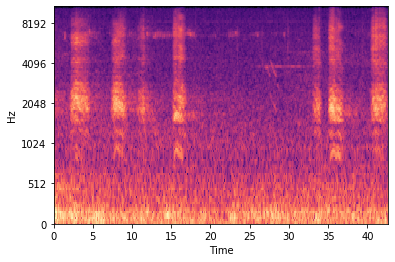

In [35]:
import librosa
from librosa import display
#y, sr = librosa.load('audio/100263-2-0-117.wav',duration=3)
a=8
y, sr = librosa.load((esc50.filename[8]))
print(esc50.category[a])
a=librosa.feature.mfcc(y=y, sr=44100)
ps = librosa.feature.melspectrogram(y=y, sr=44100, S=None,n_fft=1024,hop_length=60, power=2.0)
ps_db= librosa.power_to_db(ps, ref=np.max)
print(ps.shape)
print(sr)
librosa.display.specshow(ps_db, x_axis='time', y_axis="mel")

In [7]:
#gereksiz çalıştıma
file_list = glob("*.wav")
y, sr = librosa.load(esc50.filename[0])
list2.append(y)
k = np.abs(librosa.stft(y))
X= ToolGammatoneFb(y, 44100, 127, 0.20);
#librosa.effects.split(X, frame_length=128, hop_length=32)
Y=librosa.feature.delta(k, width=127, order=1, axis=-1, mode='interp')
X = cv2.resize(X, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
Y = cv2.resize(Y, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)



NameError: name 'list2' is not defined

In [37]:
X2=X1.reshape(128,128,1,2000)

Y2=Y1.reshape(128,128,1,2000)
data=np.concatenate((X2,Y2),axis=2)

https://programtalk.com/vs2/?source=python/3135/gammatone/gammatone/gtgram.py
http://detly.github.io/gammatone/index.html#

In [40]:
#from __future__ import print_function,keras

import os
os.getcwd()
os.chdir(r'C:\Users\burak') 
os.getcwd()

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import keras
from keras import models
from keras.models import Sequential,load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization,MaxPooling2D,Bidirectional,GRU,TimeDistributed,Reshape
from keras import backend as K


import collections

import tensorflow as tf

from tensorflow.keras import layers


# Keras modelimizi olusturalim

def get_model(no_inputs, no_outputs):
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3*5), activation='relu', input_shape=(128, 128,2),strides=1,data_format='channels_last'))
    model.add(MaxPooling2D(4*3))
    model.add(Conv2D(64, kernel_size=(3*1), activation='relu',strides=1,padding='same'))
    model.add(MaxPooling2D(4*1))
    model.add(Conv2D(128, kernel_size=(1*5), activation='relu',strides=1,padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 3), strides=None, padding='same', data_format=None))
    model.add(Conv2D(256, kernel_size=(3*3), activation='relu',strides=1,padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
    model.add(Reshape((1,256), input_shape=(None,1,1,256)))
    model.add(GRU(units=256,activation='tanh',return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Reshape((-1,50), input_shape=(None,1,1,256)))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='softmax'))   
    return model
  
#model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))

In [41]:
get_model(1,1)

In [42]:
get_model(1,1).summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 114, 114, 32)      14432     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 2, 2, 128)         204928    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 2, 1, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 2, 1, 256)        

In [11]:
y=esc50.loc[:,"category"]
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

y1 = enc.fit_transform(y)
list1 = pd.DataFrame(y1)

In [12]:
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
onehotencoder = OneHotEncoder()

y = to_categorical(list1)
y.shape



Using TensorFlow backend.


(2000, 50)

In [45]:
Y=y.reshape(2000,50,1)
K=data.reshape(2000,128,128,2)

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(K,Y,test_size=0.4,random_state=4, shuffle=True)
X2_train, X_valid, y2_train,y_valid = train_test_split(X_train,y_train,test_size=0.1,random_state=4, shuffle=True)

In [47]:
y_test=y_test.reshape(800,1,50)
y2_train=y2_train.reshape(1080,1,50)
y_valid=y_valid.reshape(120,1,50)


In [48]:
m = get_model(1,1)

m.compile(optimizer="RMSprop", loss="categorical_crossentropy", metrics=["accuracy"])
m.fit(X2_train, y2_train, batch_size=50, epochs=600, validation_data=(X_valid, y_valid))

Train on 1080 samples, validate on 120 samples
Epoch 1/600
1080/1080 [==============================] - 3s 3ms/step - loss: 3.9168 - accuracy: 0.0222 - val_loss: 3.9136 - val_accuracy: 0.0167
Epoch 2/600
1080/1080 [==============================] - 3s 3ms/step - loss: 3.9148 - accuracy: 0.0250 - val_loss: 3.9150 - val_accuracy: 0.0167
Epoch 3/600
1080/1080 [==============================] - 3s 3ms/step - loss: 3.9176 - accuracy: 0.0222 - val_loss: 3.9170 - val_accuracy: 0.0250
Epoch 4/600
1080/1080 [==============================] - 3s 2ms/step - loss: 3.9224 - accuracy: 0.0139 - val_loss: 3.9175 - val_accuracy: 0.0167
Epoch 5/600
1080/1080 [==============================] - 3s 3ms/step - loss: 3.9160 - accuracy: 0.0213 - val_loss: 3.9186 - val_accuracy: 0.0167
Epoch 6/600
1080/1080 [==============================] - 3s 3ms/step - loss: 3.9174 - accuracy: 0.0204 - val_loss: 3.9191 - val_accuracy: 0.0000e+00
Epoch 7/600
1080/1080 [==============================] - 3s 2ms/step - loss: 3.

In [49]:
ynew = m.predict_classes(X_test)

In [50]:
y_pred = to_categorical(ynew)
y.shape

(2000, 50)

In [51]:
df = pd.DataFrame(ynew)

In [52]:
def acc(y_true, y_pred):
    return np.equal(y_true, np.round(y_pred)).mean()

In [53]:
print("accuracy: " + str(acc(y_test, y_pred)))

accuracy: 0.9607971875


**gammatone filterbank**

https://www.audiocontentanalysis.org/code/helper-functions/gammatone-filterbank-2/

In [0]:
!pip install gammatone
# BSD license: https://github.com/detly/gammatone/blob/master/COPYING


In [0]:
from gammatone.plot import main
import gammatone
import librosa
y, sr = librosa.load(esc50.filename[0])



k=librosa.core.stft(y,sr,hop_length=None,win_length=50)


k.shape

(11026, 9188)